In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-01 08:04:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-01 08:04:56 (39.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Load & Preprocess Data

Data:
https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp?select=train.txt

In [ ]:
def get_lines(filename):
  """
  Reads filename and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with on string per line from the target filename
  """
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
file_name = '/content/drive/MyDrive/Dataset/emotions_dataset_for_nlp/train.txt'
input_lines = get_lines(file_name)
input_lines[:10]

['i didnt feel humiliated;sadness\n',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness\n',
 'im grabbing a minute to post i feel greedy wrong;anger\n',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love\n',
 'i am feeling grouchy;anger\n',
 'ive been feeling a little burdened lately wasnt sure why that was;sadness\n',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise\n',
 'i feel as confused about life as a teenager or as jaded as a year old man;fear\n',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy\n',
 'i feel romantic too;love\n']

In [ ]:
import pandas as pd
def preprocess_text(file_name):
  input_lines = get_lines(file_name)
  samples = []
  for line in input_lines:
    line_data = {}
    target_text_split = line.split(";")
    line_data['text'] = target_text_split[0]
    line_data['target'] = target_text_split[1].lower().strip()
    samples.append(line_data)
  return pd.DataFrame(samples)

In [ ]:
train_df = preprocess_text('/content/drive/MyDrive/Dataset/emotions_dataset_for_nlp/train.txt')
test_df = preprocess_text('/content/drive/MyDrive/Dataset/emotions_dataset_for_nlp/test.txt')
val_df = preprocess_text('/content/drive/MyDrive/Dataset/emotions_dataset_for_nlp/val.txt')
train_df.head()

,text,target
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train_df.target.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: target, dtype: int64

In [ ]:
# Convert abstract text line into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(16000, 2000, 2000)

## Make numeric labels (ML models require numeric labels) - one hot encode labels

## sklearn one-hot

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_en = OneHotEncoder(sparse=False) # Tensorflow is incompatible with sparse matrix
train_labels_one_hot = one_hot_en.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_en.transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_en.transform(val_df['target'].to_numpy().reshape(-1,1))
train_labels_one_hot[:5]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

## tensorflow one-hot

In [ ]:
class_names = train_df['target'].unique()
num_classes = len(class_names)
class_names, num_classes

(array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
       dtype=object), 6)

In [ ]:
def encode_labels(train_labels, val_labels, test_labels):
    """ Assigns a numeric value to each label since some are subject's names """
    found_labels = []
    index = 0
    mapping = {}
    for i in train_labels:
        if i in found_labels:
            continue
        mapping[i] = index
        index += 1
        found_labels.append(i)
    return [mapping[i] for i in train_labels], [mapping[i] for i in val_labels],[mapping[i] for i in test_labels], mapping

train_labels, val_labels, test_labels, mapping = encode_labels(train_df['target'].to_numpy(), val_df['target'].to_numpy(), test_df['target'].to_numpy())
mapping, train_labels[:5], train_df['target'].to_numpy()[:5]

({'anger': 1, 'fear': 4, 'joy': 5, 'love': 2, 'sadness': 0, 'surprise': 3},
 [0, 0, 1, 2, 1],
 array(['sadness', 'sadness', 'anger', 'love', 'anger'], dtype=object))

In [ ]:
one_hot_train_labels = tf.one_hot(indices=train_labels, depth=num_classes)
one_hot_val_labels = tf.one_hot(indices=val_labels, depth=num_classes)
one_hot_test_labels = tf.one_hot(indices=test_labels, depth=num_classes)
one_hot_train_labels[:5]

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Integer encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded[:5], train_df['target'].to_numpy()[:5]

(array([4, 4, 0, 3, 0]),
 array(['sadness', 'sadness', 'anger', 'love', 'anger'], dtype=object))

# Model 0: Baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

history_model_0 = model_0.fit(X = train_sentences,
                              y = train_labels) # must use train_labels_encoded, 
                                                        # train_labels_one_hot doesn't work

In [ ]:
model_0.score(X = val_sentences,
              y = val_labels)

0.641

# Vectorization and Embedding

## Vectorizer

In [ ]:
import numpy as np
sent_len = [len(sentence.split()) for sentence in train_sentences] 
# .split() split sentences into individual token

np.mean(sent_len)

19.1663125

(array([ 851., 1790., 1878., 1917., 1834., 2134., 1264., 1042.,  891.,
         608.,  609.,  354.,  256.,  197.,  132.,  119.,   73.,   33.,
          12.,    6.]),
 array([ 2. ,  5.2,  8.4, 11.6, 14.8, 18. , 21.2, 24.4, 27.6, 30.8, 34. ,
        37.2, 40.4, 43.6, 46.8, 50. , 53.2, 56.4, 59.6, 62.8, 66. ]),
 <a list of 20 Patch objects>)

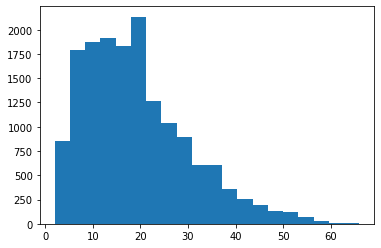

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_len, bins=20)

In [ ]:
output_seq_len = round(np.percentile(sent_len, 99))
output_seq_len

52

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences) # fit

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
i am thankful for not attending therapy but am really no further forward in fact probably feeling more isolated misunderstood and lonely in it

Length of text: 24

Vectorized text: [[   2   24  330   16   26 2272 1893   19   24   41   96 1089  783   12
   311  336    9   38  549 2887    4  364   12   13    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in training vocab? (max_tokens)
text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(text_vocab)}')
print(f'Most common words in the vocab: {text_vocab[:5]}')
print(f'Least common words in the vocab: {text_vocab[-5:]}')

Number of words in vocab: 15214
Most common words in the vocab: ['', '[UNK]', 'i', 'feel', 'and']
Least common words in the vocab: ['aahhh', 'aac', 'aaaand', 'aaaaand', 'aaaaaaand']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 52,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Embedding

In [ ]:
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim = len(text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')

In [ ]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')

vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 i am thankful for not attending therapy but am really no further forward in fact probably feeling more isolated misunderstood and lonely in it

Sentence after vectorization:
 [[   2   24  330   16   26 2272 1893   19   24   41   96 1089  783   12
   311  336    9   38  549 2887    4  364   12   13    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02809387 -0.04185973 -0.01185056 ...  0.04186554 -0.02548292
   -0.00993829]
  [-0.02108677  0.01820273  0.03718479 ... -0.04545115  0.0300664
   -0.04808471]
  [-0.03109918  0.01616578 -0.0407323  ... -0.03657935 -0.04018811
    0.00700139]
  ...
  [-0.03249587  0.03918021 -0.04225766 ...  0.02594507 -0.02268258
    0.0421241 ]
  [-0.03249587  0.03918021 -0.04225766 ...  0.02594507 -0.02268258
    0.0421241 ]
  [-0.03249587  0.03918021 -0.04225766 ...  0.02594507 -0.02268258
    0.04

# Create Datasets

In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, one_hot_train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, one_hot_test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, one_hot_val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

# Model 1: Conv1D

In [ ]:
import os
def create_model_checkpoint(model_name, save_path = 'model_experiment'):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            monitor = 'val_loss',
                                            verbose = 0,
                                            save_best_only = True)

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=[], dtype = tf.string, name = 'input_layer')
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation='relu')(token_embedding)
x = layers.Conv1D(32, 5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1')

model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 52)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 52, 128)          1947392   
                                                                 
 conv1d (Conv1D)             (None, 52, 64)            41024     
                                                                 
 conv1d_1 (Conv1D)           (None, 52, 32)            10272     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                    

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              validation_data = val_dataset,
                              callbacks = [create_model_checkpoint(model_1.name)])

Epoch 1/5
500/500 [==============================] - 17s 15ms/step - loss: 1.1028 - accuracy: 0.5756 - val_loss: 0.4658 - val_accuracy: 0.8490
Epoch 2/5
500/500 [==============================] - 7s 13ms/step - loss: 0.2616 - accuracy: 0.9078 - val_loss: 0.3445 - val_accuracy: 0.8930
Epoch 3/5
500/500 [==============================] - 5s 11ms/step - loss: 0.1244 - accuracy: 0.9572 - val_loss: 0.3632 - val_accuracy: 0.8955
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0727 - accuracy: 0.9764 - val_loss: 0.3948 - val_accuracy: 0.8955
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0494 - accuracy: 0.9847 - val_loss: 0.4536 - val_accuracy: 0.8945


In [ ]:
model_1.evaluate(val_dataset)

63/63 [==============================] - 0s 5ms/step - loss: 0.4536 - accuracy: 0.8945


[0.4535501003265381, 0.8945000171661377]

In [ ]:
model_1.evaluate(test_dataset)

63/63 [==============================] - 0s 5ms/step - loss: 0.3988 - accuracy: 0.8990


[0.3987589478492737, 0.8989999890327454]

In [ ]:
model_1.predict(['i feel romantic'])

array([[1.34315906e-06, 1.79241897e-06, 9.79681015e-01, 1.04781715e-02,
        4.05546689e-06, 9.83364321e-03]], dtype=float32)

In [ ]:
model_1.save('model_1')

INFO:tensorflow:Assets written to: model_1/assets


In [ ]:
model_1_load = tf.keras.models.load_model('model_1')
model_1_load.evaluate(test_dataset)

63/63 [==============================] - 0s 5ms/step - loss: 0.3988 - accuracy: 0.8990


[0.3987589478492737, 0.8989999890327454]

# Model 2: LSTM

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=[], dtype=tf.string, name='input_layer')
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.LSTM(10, return_sequences=True)(token_embedding)
x = layers.LSTM(10, return_sequences=True)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_lstm')

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['acc'])

model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 52)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 52, 128)          1947392   
                                                                 
 lstm (LSTM)                 (None, 52, 10)            5560      
                                                                 
 lstm_1 (LSTM)               (None, 52, 10)            840       
                                                                 
 flatten_1 (Flatten)         (None, 520)               0         
                                                      

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              validation_data = val_dataset,
                              callbacks = [create_model_checkpoint(model_2.name)])

Epoch 1/5
499/500 [============================>.] - ETA: 0s - loss: 0.7229 - acc: 0.7454

INFO:tensorflow:Assets written to: model_experiment/model_2_lstm/assets


INFO:tensorflow:Assets written to: model_experiment/model_2_lstm/assets


500/500 [==============================] - 55s 90ms/step - loss: 0.7226 - acc: 0.7456 - val_loss: 0.5818 - val_acc: 0.8205
Epoch 2/5
500/500 [==============================] - 17s 35ms/step - loss: 0.2266 - acc: 0.9273 - val_loss: 0.6296 - val_acc: 0.8325
Epoch 3/5
500/500 [==============================] - 17s 34ms/step - loss: 0.1254 - acc: 0.9621 - val_loss: 0.7347 - val_acc: 0.8305
Epoch 4/5
500/500 [==============================] - 17s 34ms/step - loss: 0.0930 - acc: 0.9712 - val_loss: 0.7302 - val_acc: 0.8355
Epoch 5/5
500/500 [==============================] - 17s 33ms/step - loss: 0.0755 - acc: 0.9771 - val_loss: 0.7954 - val_acc: 0.8400


In [ ]:
model_2.evaluate(val_dataset)

63/63 [==============================] - 1s 13ms/step - loss: 0.7954 - acc: 0.8400


[0.7954180240631104, 0.8399999737739563]

In [ ]:
model_2.evaluate(test_dataset)

63/63 [==============================] - 1s 13ms/step - loss: 0.7697 - acc: 0.8375


[0.7696695923805237, 0.8374999761581421]

# Tensorflow Hub

## Universal Sentence Encoder (USE)

In [ ]:
import tensorflow_hub as hub
use_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=True, name = 'universal_sentence_encoder') # trainable = False, no fine_tuning

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence: {random_train_sentence}')
use_embedded_sentence = use_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:20]}')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence: i feel very disgusted by that i cant tolerated her actions anymore by writing this post
Sentence after embedding:
[ 0.00875793  0.03338599 -0.02275609 -0.02101293 -0.02253612  0.00084866
  0.04161102  0.06259531  0.04605292  0.03570007 -0.00355593  0.02099572
  0.06115022 -0.03877518 -0.01621486 -0.11257262 -0.01649475 -0.00501209
  0.06463665  0.04314382]
Length of sentence embedding: 512


### Simple Dense after USE

In [ ]:
from tensorflow.keras import layers
input = layers.Input(shape=[], dtype=tf.string, name='input_layer')
pretrained_embed = use_embedding_layer(input)
x = layers.Dense(128, activation = 'relu')(pretrained_embed)
x = layers.Dropout(0.2)(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model_2_use_dense = tf.keras.Model(input, output, name='model_2_use_dense')

model_2_use_dense.compile(loss='categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics=['acc'])

In [ ]:
model_2_use_dense.summary()

Model: "model_2_use_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
Total params: 256,864,262
Trainable params: 256,864,262
Non-trainable params: 0
___________________________________

In [ ]:
history_model_2_use_dense = model_2_use_dense.fit(train_dataset,
                                                  epochs=5,
                                                  validation_data = val_dataset,
                                                  callbacks = [create_model_checkpoint(model_2_use_dense.name)])

Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 0.9228 - acc: 0.6649INFO:tensorflow:Assets written to: model_experiment/model_2_use_dense/assets


INFO:tensorflow:Assets written to: model_experiment/model_2_use_dense/assets


500/500 [==============================] - 150s 281ms/step - loss: 0.9228 - acc: 0.6649 - val_loss: 0.5972 - val_acc: 0.7860
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 0.1651 - acc: 0.9432INFO:tensorflow:Assets written to: model_experiment/model_2_use_dense/assets


INFO:tensorflow:Assets written to: model_experiment/model_2_use_dense/assets


500/500 [==============================] - 138s 277ms/step - loss: 0.1651 - acc: 0.9432 - val_loss: 0.5552 - val_acc: 0.8215
Epoch 3/5
500/500 [==============================] - 117s 234ms/step - loss: 0.0300 - acc: 0.9916 - val_loss: 0.6741 - val_acc: 0.8125
Epoch 4/5
500/500 [==============================] - 117s 234ms/step - loss: 0.0147 - acc: 0.9958 - val_loss: 0.7439 - val_acc: 0.8025
Epoch 5/5
500/500 [==============================] - 117s 233ms/step - loss: 0.0110 - acc: 0.9967 - val_loss: 0.7526 - val_acc: 0.8045


In [ ]:
model_2_use_dense.evaluate(val_dataset)

63/63 [==============================] - 1s 16ms/step - loss: 0.7526 - acc: 0.8045


[0.7525956630706787, 0.8044999837875366]

In [ ]:
model_2_use_dense.evaluate(test_dataset)

63/63 [==============================] - 1s 17ms/step - loss: 0.8121 - acc: 0.7975


[0.812135636806488, 0.7975000143051147]

In [ ]:
model_2_use_dense.save('model_2_use_dense.h5')

## nnlm

In [ ]:
import tensorflow_hub as hub
nnlm_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128/2',
                                        trainable=True, name = 'nnlm') # trainable = False, no fine_tuning

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence: {random_train_sentence}')
nnlm_embedded_sentence = nnlm_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{nnlm_embedded_sentence[0][:20]}')
print(f'Length of sentence embedding: {len(nnlm_embedded_sentence[0])}')

Random sentence: i remember a couple of years ago i was feeling romantic and dreamy and asked him wonder if we ll celebrate our th anniversary
Sentence after embedding:
[ 0.6476727   0.14424737  0.14189798  0.02576951  0.19134645  0.02180259
  0.05892999 -0.06240362 -0.0208896  -0.11873399  0.10887104 -0.2734278
 -0.15727165 -0.1909535   0.22312124  0.09911098 -0.15988976 -0.2222449
  0.01734188  0.23331791]
Length of sentence embedding: 128


In [ ]:
from tensorflow.keras import layers
input = layers.Input(shape=[], dtype=tf.string, name='input_layer')
embed = nnlm_embedding_layer(input)
x = layers.Dense(128, activation='relu')(embed)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model_2_nnlm_dense = tf.keras.Model(input, output, name='model_2_nnlm_dense')

model_2_nnlm_dense.compile(loss='categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics=['acc'])

In [ ]:
history_model_2_nnlm_dense = model_2_nnlm_dense.fit(train_dataset,
                                                  epochs=5,
                                                  validation_data = val_dataset,
                                                  callbacks = [create_model_checkpoint(model_2_nnlm_dense.name)])

Epoch 1/5
499/500 [============================>.] - ETA: 0s - loss: 0.9595 - acc: 0.6586INFO:tensorflow:Assets written to: model_experiment/model_2_nnlm_dense/assets


INFO:tensorflow:Assets written to: model_experiment/model_2_nnlm_dense/assets


500/500 [==============================] - 26s 49ms/step - loss: 0.9594 - acc: 0.6587 - val_loss: 0.4705 - val_acc: 0.8470
Epoch 2/5
499/500 [============================>.] - ETA: 0s - loss: 0.2549 - acc: 0.9128INFO:tensorflow:Assets written to: model_experiment/model_2_nnlm_dense/assets


INFO:tensorflow:Assets written to: model_experiment/model_2_nnlm_dense/assets


500/500 [==============================] - 25s 49ms/step - loss: 0.2555 - acc: 0.9126 - val_loss: 0.3975 - val_acc: 0.8725
Epoch 3/5
500/500 [==============================] - 18s 37ms/step - loss: 0.1072 - acc: 0.9656 - val_loss: 0.4578 - val_acc: 0.8635
Epoch 4/5
500/500 [==============================] - 18s 37ms/step - loss: 0.0677 - acc: 0.9789 - val_loss: 0.5002 - val_acc: 0.8670
Epoch 5/5
500/500 [==============================] - 19s 37ms/step - loss: 0.0534 - acc: 0.9831 - val_loss: 0.6067 - val_acc: 0.8570


In [ ]:
load_model_2_nnlm_dense = tf.keras.models.load_model('model_experiment/model_2_nnlm_dense')

In [ ]:
load_model_2_nnlm_dense.evaluate(val_dataset)

63/63 [==============================] - 0s 4ms/step - loss: 0.3975 - acc: 0.8725


[0.39745861291885376, 0.8725000023841858]

In [ ]:
load_model_2_nnlm_dense.evaluate(test_dataset), model_2_nnlm_dense.evaluate(test_dataset)

63/63 [==============================] - 0s 6ms/step - loss: 0.5776 - acc: 0.8535


([0.3871552050113678, 0.8640000224113464],
 [0.5775756239891052, 0.8535000085830688])

In [ ]:
pred= load_model_2_nnlm_dense.predict(test_dataset)
pred_prob = tf.reduce_max(pred, axis=1)
pred = tf.argmax(pred, axis=1)
pred.numpy()[:5], test_labels[:5]

(array([0, 0, 0, 5, 0]), [0, 0, 0, 5, 0])

In [ ]:
from helper_functions import calculate_results
calculate_results(y_true = test_labels,
                  y_pred = pred)

{'accuracy': 86.4,
 'f1': 0.863630277795882,
 'precision': 0.8634984306075528,
 'recall': 0.864}

In [ ]:
mapping_new = {y:x for x,y in mapping.items()}
mapping_new

{0: 'sadness', 1: 'anger', 2: 'love', 3: 'surprise', 4: 'fear', 5: 'joy'}

In [ ]:
test_labels_word = [mapping_new[i] for i in test_labels]
pred_word = [mapping_new[i] for i in pred.numpy()]

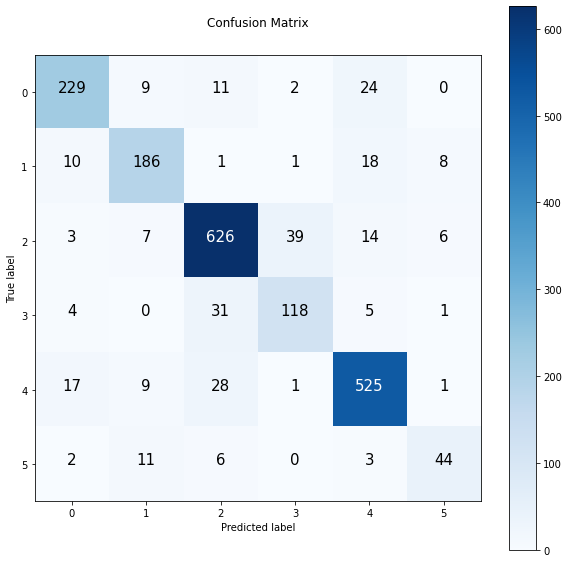

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true = test_labels_word, y_pred = pred_word)

In [ ]:
load_model_2_nnlm_dense.save('load_model_2_nnlm_dense.h5')

In [ ]:
test_df = pd.DataFrame({'text': test_sentences,
                        'target': test_labels,
                        'pred': pred,
                        'pred_prob': pred_prob})
test_df

,text,target,pred,pred_prob
0,im feeling rather rotten so im not very ambiti...,0,0,0.998182
1,im updating my blog because i feel shitty,0,0,0.999914
2,i never make her separate from me because i do...,0,0,0.975422
3,i left with my bouquet of red and yellow tulip...,5,5,0.998244
4,i was feeling a little vain when i did this one,0,0,0.996170
...,...,...,...,...
1995,i just keep feeling like someone is being unki...,1,1,0.654295
1996,im feeling a little cranky negative after this...,1,1,0.981502
1997,i feel that i am useful to my people and that ...,5,5,0.979670
1998,im feeling more comfortable with derby i feel ...,5,5,0.998843


In [ ]:
most_wrong = test_df[test_df['target'] != test_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong.head()

,text,target,pred,pred_prob
229,i am truly unfortunate the majority of the tim...,4,0,0.999801
726,i lift different now because it hurt so bad th...,4,0,0.998878
249,i will practice meditation if i feel overwhelm...,3,5,0.998423
442,i had to continue to enforce my no playdate po...,1,0,0.997825
1698,i work well with almost every client ive ever ...,0,1,0.996303


In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
1889,i feel at leaving work is hot and complicated ...,2,3,0.345881
53,i can t stop the anxiety i feel when i m alone...,0,4,0.319894
1819,i feel so frustrated because i had a long week...,1,5,0.310349
756,getting sent on a company expense trip to anot...,5,1,0.299554
776,i cant help but think if id just shut up if id...,0,3,0.266082


In [ ]:
class_names

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
most_wrong.iloc[2]['text']

'i will practice meditation if i feel overwhelmed and hopefully become successful in peaceful practice'